<a href="https://colab.research.google.com/github/Afique1/Business-Review-by-user/blob/Alan's-works/SIT742Task2_Group32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions selection
Questions are selected based on the birthdate(day) of students [if it's even/odd then selected Q. are even/odd]

In [40]:
students = {"Afique": 11,"Alan": 10}
questions = list(range(1, 9))  # 8 questions for Part 1

assignments = {}

for student, birthdate in students.items():
  assignments[student] = []
  for question in questions:
    if (birthdate % 2 == 0 and question % 2 == 0) or (birthdate % 2 != 0 and question % 2 != 0):
      assignments[student].append(f"Q{question}")

print("Assigned Questions for part 1:\n"+"-"*40)

for student, assigned_questions in assignments.items():
  print(f"{student} (Birthdate: {students[student]}): {', '.join(assigned_questions)}")

Assigned Questions for part 1:
----------------------------------------
Afique (Birthdate: 11): Q1, Q3, Q5, Q7
Alan (Birthdate: 10): Q2, Q4, Q6, Q8


# Part 0) Read the data using Pyspark

Update and Import packages

In [41]:
#update local version of the package catalog
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install findspark
!pip install -q findspark

import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pyspark import SparkContext
# from pyspark.sql import SQLContext

`SparkSession` is the combination of SparkContext and SQLContext. So, the updated package/ will be used instead of SparkContext and SQLContext.


In [43]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BusinessReviewAnalysis") \
    .getOrCreate()

print("Spark session created successfully!")

Spark session created successfully!


Download and save the csv file locally.

In [44]:
!pip install wget

In [45]:
import wget

link_to_data1 = 'https://github.com/Afique1/Business-Review-by-user/raw/main/Dataset/meta-review-business.csv'
link_to_data2 = 'https://github.com/Afique1/Business-Review-by-user/raw/main/Dataset/review.csv'

MetaReview_Dataset = wget.download(link_to_data1)
Review_Dataset = wget.download(link_to_data2)

In [46]:
# Read the datasets into Spark DataFrames with 10 partitioning
meta_review_sdf = spark.read.csv(MetaReview_Dataset, header=True, inferSchema=True).repartition(10)
review_sdf = spark.read.csv(Review_Dataset, header=True, inferSchema=True).repartition(10)

print("Meta Review Dataset Schema:")
meta_review_sdf.printSchema()
# print("\nMeta Review Dataset Head:")
# meta_review_sdf.show(5)

print("\nReview Dataset Schema:")
review_sdf.printSchema()
# print("\nReview Dataset Head:")
# review_sdf.show(5)

Meta Review Dataset Schema:
root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)


Review Dataset Schema:
root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)



Investigate the datasets

In [47]:
print("Investigating Meta Review Dataset:")
print("Number of rows:", meta_review_sdf.count())
print("Columns:", meta_review_sdf.columns)
print("Summary Statistics:")
meta_review_sdf.describe().show()

print("\nInvestigating Review Dataset:")
print("Number of rows:", review_sdf.count())
print("Columns:", review_sdf.columns)
print("Summary Statistics:")
review_sdf.describe().show()

Investigating Meta Review Dataset:
Number of rows: 12774
Columns: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']
Summary Statistics:
+-------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|                name|             address|             gmap_id|         description|          latitude|          longitude|            category|          avg_rating|      num_of_reviews|               price|               hours|                MISC|               state|    relative_results|                 url|
+-------+--------------------+--------------------+--------------------+--------------------+

In [48]:
print("Number of partitions for meta_review_sdf:", meta_review_sdf.rdd.getNumPartitions())
print("Number of partitions for review_sdf:", review_sdf.rdd.getNumPartitions())

Number of partitions for meta_review_sdf: 10
Number of partitions for review_sdf: 10


In [49]:
# Get the SparkContext from the SparkSession
sc = spark.sparkContext

# Get the number of active cores
# In local mode, this typically corresponds to the number of threads being used
num_cores = sc.defaultParallelism

print(f"Number of cores being used by Spark: {num_cores}")

Number of cores being used by Spark: 2


Is it wise to join both sdfs?

In [50]:
# Count and print the number of unique gmap_id values in each DataFrame
unique_meta_review_count = meta_review_sdf.select("gmap_id").distinct().count()
unique_review_count = review_sdf.select("gmap_id").distinct().count()

print("\nNumber of unique gmap_id in meta_review_sdf:", unique_meta_review_count)
print("Number of unique gmap_id in review_sdf:", unique_review_count)


Number of unique gmap_id in meta_review_sdf: 12688
Number of unique gmap_id in review_sdf: 12468


## Join based on `gmap_id`

In [51]:
# Perform an inner join on the 'gmap_id' column
sdf = meta_review_sdf.join(review_sdf, on="gmap_id", how="inner")

# Show the schema and a few rows of the joined DataFrame to verify
print("Joined DataFrame Schema:")
sdf.printSchema()
sdf.count()

Joined DataFrame Schema:
root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)



498903

In [52]:
from pyspark.sql.functions import col

# Sort meta_review_sdf by gmap_id and show the top 5
print("Top 5 gmap_id in meta_review_sdf:")
meta_review_sdf.select("gmap_id").orderBy(col("gmap_id")).show(5)

# Sort review_sdf by gmap_id and show the top 5
print("\nTop 5 gmap_id in review_sdf:")
review_sdf.select("gmap_id").orderBy(col("gmap_id")).show(5)

Top 5 gmap_id in meta_review_sdf:
+--------------------+
|             gmap_id|
+--------------------+
|      1700 Willow St|
|              2nd St|
| 8225 Old Seward ...|
|        8600 King St|
|        8600 King St|
+--------------------+
only showing top 5 rows


Top 5 gmap_id in review_sdf:
+-------+
|gmap_id|
+-------+
|   NULL|
|   NULL|
|   NULL|
|   NULL|
|   NULL|
+-------+
only showing top 5 rows



# Part 1
---



## Q1.1 Some Data Wrangling

### Q1.1.1 none, null in `text` column to "no review"

### Q1.1.2 Change the format of time
in the `time` column, convert the strings from time to `yyyy-mm-dd` format
in the new column as `newtime` and show the first 5 rows.

## Q1.2 Info for `gmap_id` on the `review`

### Q1.2.1 using pyspark, calculate the number of reviews for each unique `gmap_id`
(save as float format in pyspark dataframe to show the top 5 rows)

In [53]:
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import col

Calculation based on the Review Dataset review_sdf

In [54]:
review_sdf_counts_spark = review_sdf.groupBy("gmap_id").count().withColumn("count", col("count").cast("float"))

In [55]:
review_sdf_counts_spark.orderBy(col("count").desc()).show(5)

+--------------------+-------+
|             gmap_id|  count|
+--------------------+-------+
|                NULL|46309.0|
|0x56c897b9ce6000d...| 2737.0|
|0x56c899d05892048...| 2555.0|
|0x56c897c63697ee3...| 2220.0|
|0x56c8965ee2fb87a...| 2202.0|
+--------------------+-------+
only showing top 5 rows



In [56]:
# Cross-checking the counting results
review_sdf_counts_spark.agg(spark_sum("count")).collect()[0][0] # expected to match the no. of rows as 552624

552624.0

Calculation based on the joined datafram sdf

In [57]:
sdf_counts_spark = sdf.groupBy("gmap_id").count().withColumn("count", col("count").cast("float"))

In [58]:
sdf_counts_spark.orderBy(col("count").desc()).show(5)

+--------------------+------+
|             gmap_id| count|
+--------------------+------+
|0x56c897b9ce6000d...|2737.0|
|0x56c899d05892048...|2555.0|
|0x56c897c63697ee3...|2220.0|
|0x56c8965ee2fb87a...|2202.0|
|0x56c89629bde7481...|2156.0|
+--------------------+------+
only showing top 5 rows



In [59]:
sdf_counts_spark.agg(spark_sum("count")).collect()[0][0]

498903.0

In [60]:
# A suspected phantom row indicated by 1 counted in gmap_id of "Anchorage"
sdf_counts_spark.orderBy(col("count")).show(5)

+--------------------+-----+
|             gmap_id|count|
+--------------------+-----+
|           Anchorage|  1.0|
|0x56c897c88b2e4b7...|  4.0|
|0x56c8962f33efc3b...|  5.0|
|0x56c8eb715388aae...|  5.0|
|0x5400df8600be380...|  5.0|
+--------------------+-----+
only showing top 5 rows



In [61]:
# The phantom row has been identified yet has no impact
sdf.filter(col("gmap_id") == "Anchorage").show()

sdf_phantom_cleaned = sdf.filter(col("gmap_id") != "Anchorage")
sdf_phantom_cleaned_counts_spark = sdf_phantom_cleaned.groupBy("gmap_id").count().withColumn("count", col("count").cast("float"))
sdf_phantom_cleaned_counts_spark.agg(spark_sum("count")).collect()[0][0]

+-------+----+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+-------+----+----+------+----+----+----+
|gmap_id|name|address|description|latitude|longitude|category|avg_rating|num_of_reviews|price|hours|MISC|state|relative_results|url|user_id|name|time|rating|text|pics|resp|
+-------+----+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+-------+----+----+------+----+----+----+
+-------+----+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+-------+----+----+------+----+----+----+



498903.0

### Q1.2.2 convert the pyspark df to pandas df
* create a new column `review_time` with the info of review time on hours level, add in the pandas df.
* show top 5 rows

In [62]:
df = review_sdf.toPandas() # transform the current pyspark dataframe to pandas dataframe

In [63]:
df["time"].head(10)

,time
0,1525676908252
1,1368006776281
2,1569090797829
3,1597542582178
4,1598037847651
5,None
6,1549419589149
7,"""{'time': 1598807097467, 'text': """"We all appr..."
8,1495309866441
9,1562915528083


In [64]:
import re

def clean_and_convert(val):
    try:
        if pd.isnull(val):
            return pd.NaT

        # Directly handle numeric values
        if isinstance(val, (int, float)):
            return pd.to_datetime(int(val), unit="ms")

        # Handle dictionary-like objects
        if isinstance(val, dict) and "time" in val:
            return pd.to_datetime(int(val["time"]), unit="ms")

        # Convert to string and strip whitespace
        val_str = str(val).strip()

        # Try to extract timestamp from dictionary-like string
        match = re.search(r"[\"']?time[\"']?\s*:\s*(\d{13})", val_str)
        if match:
            return pd.to_datetime(int(match.group(1)), unit="ms")

        # Fallback: check if the string itself is a 13-digit number
        if re.fullmatch(r"\d{13}", val_str):
            return pd.to_datetime(int(val_str), unit="ms")

    except Exception:
        pass

    return pd.NaT

In [27]:
df["review_time"] = df["time"].apply(clean_and_convert) # create the column reivew_time with the information of review time

In [28]:
df[["time", "review_time"]].sample(20)

,time,review_time
532902,1565557057523,2019-08-11 20:57:37.523
29802,1566817509629,2019-08-26 11:05:09.629
452125,1552625513544,2019-03-15 04:51:53.544
218444,1604889363209,2020-11-09 02:36:03.209
109808,1572730946101,2019-11-02 21:42:26.101
186831,1515120643553,2018-01-05 02:50:43.553
281078,1521612639962,2018-03-21 06:10:39.962
328813,1558029502524,2019-05-16 17:58:22.524
448712,1561953803115,2019-07-01 04:03:23.115
212153,1489298894568,2017-03-12 06:08:14.568


In [29]:
df["review_hour"] = df["review_time"].apply(lambda x: int(x.hour) if pd.notnull(x) else None)
df[["time", "review_time", "review_hour"]].sample(20)

,time,review_time,review_hour
373642,None,NaT,NaN
275638,1593787804856,2020-07-03 14:50:04.856,14.0
147098,1524109798116,2018-04-19 03:49:58.116,3.0
379127,1619415928535,2021-04-26 05:45:28.535,5.0
274348,1598300408991,2020-08-24 20:20:08.991,20.0
221588,1563079933481,2019-07-14 04:52:13.481,4.0
392250,1595699898721,2020-07-25 17:58:18.721,17.0
497909,1500601692817,2017-07-21 01:48:12.817,1.0
86824,None,NaT,NaN
293281,1465088566379,2016-06-05 01:02:46.379,1.0


In [30]:
df["review_hour"] = df["review_hour"].astype("Int64")
df["review_time"] = df["review_hour"]
df = df.drop("review_hour", axis=1)
df.head(20)

,user_id,name,time,rating,text,pics,resp,gmap_id,review_time
0,1.1199583254827408e+20,rudd plate,1525676908252,5,"One of my favorite spots in girdwood, food is ...",None,None,0x56c87b49c26f5107:0xec4056657ef54014,7
1,1.0478867993645928e+20,tabusoro 2018,1368006776281,5,My wife and I went down to check out some prop...,None,None,0x56c8de19a2d52fb9:0xd4de9f782a9ea8d0,9
2,1.0931108707710702e+20,Max Berry,1569090797829,5,A haven for spoiled dogs. The absolute best k...,None,"{'time': 1573931035889, 'text': 'Hi Max,\nThan...",0x56c899d4b406a22f:0x17bbaf5c2b5d5e6d,18
3,1.0752206066654141e+20,bryan leggieri,1597542582178,5,None,None,None,0x51325ab55e36bf49:0x2d274b98cb425902,1
4,1.0043345819386066e+20,Robert Walker,1598037847651,5,Excellent prices and very professional staff,None,None,0x56c8de139d65cb69:0xf0491769409e7959,19
5,Marco T's has officially earned my a spot on m...,None,None,None,None,None,None,None,<NA>
6,1.1434038596819003e+20,Derrick Spain,1549419589149,5,the Knik pizza was awesome. lots of options an...,None,None,0x56c8e0bd31c76473:0xdea4696a0c45fd8d,2
7,"course in Alaska.""",None,"""{'time': 1598807097467, 'text': """"We all appr...",I believe we have the best course in Alaska a...,0x56c91d88841c3625:0x2ecd4d1a74fecbae,None,None,None,17
8,1.0845867497873875e+20,Pinkie Pie,1495309866441,5,None,None,None,0x513244cdbc58b5ab:0x4e07ddb288998e,19
9,1.0711897751685569e+20,Jaimee Buzga,1562915528083,3,None,None,None,0x56c1320b8fe2e389:0xb356c28fe92eca6b,7


In [31]:
invalid_rows = df[df["review_time"].isna()]
print(invalid_rows[["time", "review_time"]])

        time  review_time
5       None         <NA>
22      None         <NA>
46      None         <NA>
49      None         <NA>
63      None         <NA>
...      ...          ...
552562  None         <NA>
552580  None         <NA>
552598  None         <NA>
552605  None         <NA>
552623  None         <NA>

[29897 rows x 2 columns]


In [32]:
def contains_timestamp(val):
    if isinstance(val, str):
        match = re.search(r"\b\d{13}\b", val)
        return bool(match)
    return False

In [33]:
print(invalid_rows[~invalid_rows["time"].isna()]["time"])
print()

mask = invalid_rows["time"].notnull() & invalid_rows["time"].apply(contains_timestamp)
shortlist = invalid_rows[mask]

print(shortlist[["time"]]) # emptiness means no more entries with extractable 13-digit timestamps

225        super soggy bread and the cheese choice was b...
276        could probably spend at least a week eating h...
518        asking me to move it to 5. I rearranged my sc...
837        expecting a call but nothing. I called back a...
924        I took her for a spin and it drove like a new...
                                ...                        
551665     because they have a Specials menu that is...w...
551771                                     Xander and Tina.
551842                there is no way not to give 5 stars."
552280                                  good house fries...
552521     and everything was small to accommodate all c...
Name: time, Length: 5082, dtype: object

Empty DataFrame
Columns: [time]
Index: []


In [34]:
df[["time", "review_time"]].head(10)

,time,review_time
0,1525676908252,7
1,1368006776281,9
2,1569090797829,18
3,1597542582178,1
4,1598037847651,19
5,None,<NA>
6,1549419589149,2
7,"""{'time': 1598807097467, 'text': """"We all appr...",17
8,1495309866441,19
9,1562915528083,7


### Q1.2.3 Relationship between `gmap_id` and `review_time` [both discrete]
* which time people usually review?
* which time do they review the less amount?
* How many business is reviewed in the morning? [6<= x <12 ; 06:00-11:59]

In [35]:
sns.set_style("whitegrid")

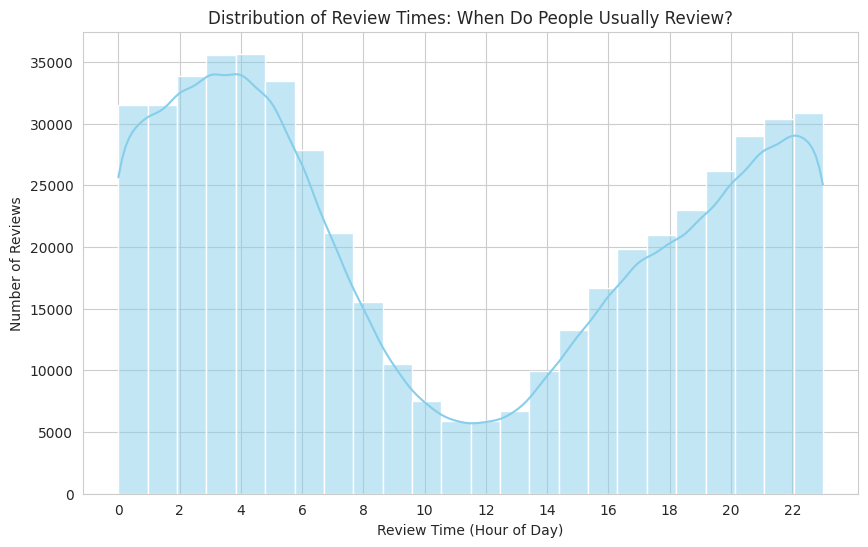

In [36]:
# Visualization 1: Histogram of review_time to see usual review times
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_time', bins=24, kde=True, color='skyblue')
plt.xlabel('Review Time (Hour of Day)')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Times: When Do People Usually Review?')
plt.xticks(range(0, 24, 2))
plt.show()

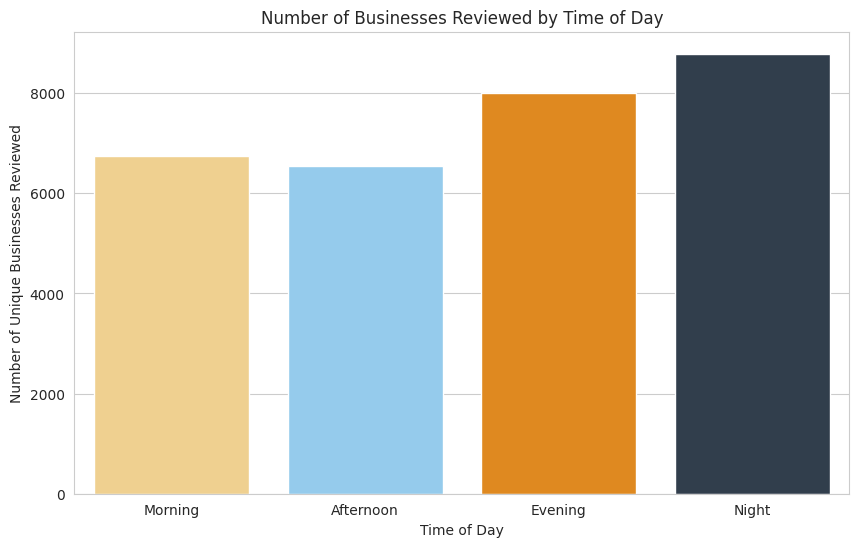

In [37]:
# Visualization 2: Bar plot of unique businesses reviewed per hour bin (morning: 6-12, afternoon: 12-18, evening: 18-24, night: 0-6)
# Create hour bins for categorization
def get_time_bin(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['time_bin'] = df['review_time'].apply(get_time_bin)

# Count unique gmap_id per time bin
business_per_bin = df.groupby('time_bin')['gmap_id'].nunique().reset_index()
business_per_bin.columns = ['Time Bin', 'Unique Businesses Reviewed']

time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
custom_palette = {
    'Morning': '#FFD580',    # Soft sunrise gold
    'Afternoon': '#87CEFA',  # Bright sky blue
    'Evening': '#FF8C00',    # Deep orange glow
    'Night': '#2C3E50'       # Midnight navy
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=business_per_bin,
    x='Time Bin', y='Unique Businesses Reviewed',
    hue='Time Bin', palette=custom_palette, legend=False,
    order=time_order)
plt.xlabel('Time of Day')
plt.ylabel('Number of Unique Businesses Reviewed')
plt.title('Number of Businesses Reviewed by Time of Day')
plt.show()

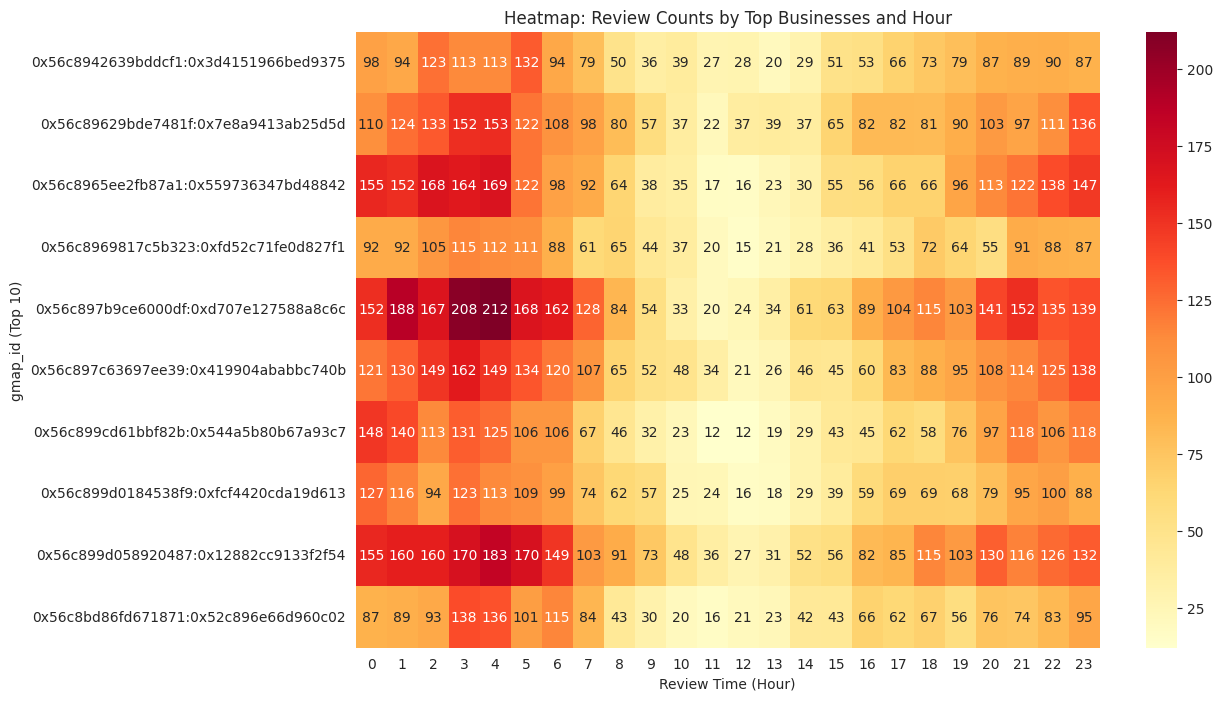

In [38]:
# Visualization 3: Corrected Heatmap of review counts by gmap_id and review_time
top_gmap = df['gmap_id'].value_counts().head(10).index
df_top = df[df['gmap_id'].isin(top_gmap)]

# Pivot table to count occurrences of rows for each gmap_id and review_time combination
pivot_table = df_top.pivot_table(index='gmap_id', columns='review_time', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt='d')
plt.xlabel('Review Time (Hour)')
plt.ylabel('gmap_id (Top 10)')
plt.title('Heatmap: Review Counts by Top Businesses and Hour')
plt.show()

## Q1.3 join `meta-business` with the current df on `gmap_id`

### Q1.3.1 Find the `workday` with most reviews

### Q1.3.2 Category of business name with most review in that day
* in that day which business (the business `name`) has the highest avg rating [max(avg(most_review_day))]
* Find the `category` of the business `name`

### Q1.3.3 Exploration on business `name`
* peak hour of that catefory
* Plot historam

[write about the insight]

## Q1.4 Top 30 words by year
* For the reviews on each of the submissions, work on all the review content and find out the `top 30`
most common words;
* Also generate separate `word cloud` visualizations for `different years`( by grouping
the reviews by review year )
* write down the insights in the markdown cell.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
from datetime import datetime

In [93]:
# Wrap part of codes in Q1.2.2 as a function for time in extracted as datetime

# Defining a regular function in Python as usual
def parse_time_to_datetime(val):
    """
    Parses various time formats into Python datetime.
    Returns None if parsing fails.
    """
    try:
        if val is None:
            return None

        # Numeric timestamp (int/float)
        if isinstance(val, (int, float)):
            return datetime.fromtimestamp(int(val) / 1000.0)

        # Dict-like string containing "time": 13-digit
        val_str = str(val).strip()
        match = re.search(r'["\']?time["\']?\s*:\s*(\d{13})', val_str)
        if match:
            return datetime.fromtimestamp(int(match.group(1)) / 1000.0)

        # Pure 13-digit string
        if re.fullmatch(r"\d{13}", val_str):
            return datetime.fromtimestamp(int(val_str) / 1000.0)

    except Exception:
        return None
    return None

# Customising function for distributed computation by Spark
parse_time_udf = F.udf(parse_time_to_datetime, TimestampType()) # telling the return type

def extract_review_datetime_spark(spark_df, time_col="time", output_col="review_datetime"):
    """
    Adds a column with parsed datetime from a timestamp-like column in a Spark DataFrame.
    """
    return spark_df.withColumn(output_col, parse_time_udf(F.col(time_col)))

In [94]:
review_sdf_with_datetime = extract_review_datetime_spark(
    review_sdf,
    time_col="time",
    output_col="review_datetime"
)

review_sdf_with_datetime.select("time", "review_datetime").show(10, truncate=False)

+-------------+-----------------------+
|time         |review_datetime        |
+-------------+-----------------------+
|1520663824616|2018-03-10 06:37:04.616|
|1343946019370|2012-08-02 22:20:19.37 |
|1608311022785|2020-12-18 17:03:42.785|
|1572987681590|2019-11-05 21:01:21.59 |
|1575342018108|2019-12-03 03:00:18.108|
|1595901220198|2020-07-28 01:53:40.198|
|1502328354507|2017-08-10 01:25:54.507|
|1535334333485|2018-08-27 01:45:33.485|
|1573621871458|2019-11-13 05:11:11.458|
|1615443957285|2021-03-11 06:25:57.285|
+-------------+-----------------------+
only showing top 10 rows



In [95]:
df_dt = review_sdf_with_datetime.toPandas() # transform the current pyspark dataframe to pandas dataframe
df_dt.columns

Index(['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id',
       'review_datetime'],
      dtype='object')

In [96]:
df_dt['review_datetime'] = pd.to_datetime(df_dt['review_datetime'], errors='coerce')
df_dt['review_year'] = df_dt['review_datetime'].dt.year
df_dt.columns

Index(['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id',
       'review_datetime', 'review_year'],
      dtype='object')

In [97]:
# Function to clean and tokenize
def clean_tokenize(text):
    if pd.isnull(text):
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters and spaces
    return text.split()

In [98]:
# Apply function to create a 'words' column
df_dt["words"] = df_dt["text"].apply(clean_tokenize)

# Explode the list of words into separate rows
words_df = df_dt.explode("words")

# Drop empty strings if any
words_df = words_df[words_df["words"] != ""]

# Count word frequencies
word_counts = (
    words_df.groupby("words")
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

In [99]:
# Top 30 overall
top30_words = word_counts.head(30)
top30_words.insert(0, "rank", range(1, len(top30_words) + 1))
print(top30_words.to_string(index=False))

 rank   words  count
    1     the 236974
    2     and 203328
    3       a 130257
    4      to 125101
    5       i  93435
    6   great  80651
    7      is  74563
    8     was  73728
    9      of  72303
   10     for  70198
   11      in  66347
   12    good  61911
   13    food  60870
   14      it  53529
   15    they  49269
   16   place  46149
   17 service  43820
   18     you  41555
   19      my  40136
   20     but  39520
   21    very  38124
   22    with  37426
   23     are  36329
   24    have  34698
   25    this  33786
   26      on  31202
   27     not  28472
   28    that  28304
   29   staff  27527
   30    nice  25593


## Q1.5 Analysis on business `name` and `review`
* find the number of unique business `reviewers` and its `category` (find out the highest distinct count of reviewers on business / category level)
* When `reviewers` submitted their review? [add visualization and write in markdown]

## Q1.6 Build recommendation for business
(by using reviews, ratings, and its categories)

### Q1.6.1 Write down the strategy to build Recommendation
create own strategy or leverage KNN on collaborative filtering.
* Write about the logic

### Q1.6.2 Implement the strategy
add sufficient comments where required

## Q1.7 Analysis on `Rating`s for each submission review

### Q1.7.1 Relationship of `rating` and `business categories`

write down the insights

### Q1.7.2 Focus on lower ratings
[Select a threshold to considered as lower]
* Find the most common words
* Whats the reason behind lower rating?

## Q1.8 Reviewer level with all the reviewed business history (submission of the review)

### Q1.8.1 Create a `user_business_list`
* check reviewer level for reviewed business
* sort the review based on review time (`new_time` column)
* save the business name, for each reviewer into the `user_business_list`
* for the list: print the `number of elements` / `number of business name` for each reviewers **[before removing]**

### Q1.8.2 Repeated business names for the same user/reviewer?
* remove those duplicated business names under same user (take unique business name)
* print the `number of business name` for each reviewers **[after removing]**

### Q1.8.3 user similarities in the past reviewed business
* Write down the strategy for implementation with sufficient explanation
* Check on the `user_business_list` and find the user similarities according to their past reviewed business.

Hint: you might consider to use `encoding` for each of the business names and then calculate the difference of the users.

# Part 2
---

## Q2.1 Seasonality Pattern

## Q2.2 ARIMA Model

## Q2.3 Analyze Annual Report of Indigenous Strategy
link to the pdf

### Data Extraction

### Data Analysis

### Insights